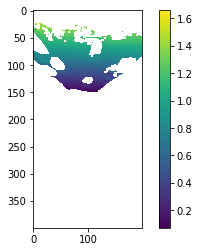

In [23]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pyransac3d 
from scipy.spatial.transform import Rotation as R

RESOLUTION = 0.005
with open('map-20220122-155134.pkl', 'rb') as f:
    data = pickle.load(f)

data = np.array(data)
height_map = data[0]
plt.imshow(height_map)
plt.colorbar()

plt.show()


In [2]:
height_map.shape

(400, 200)

In [3]:
xgrid, ygrid = np.meshgrid(np.linspace(0, height_map.shape[1]*RESOLUTION, height_map.shape[1]), np.linspace(0, height_map.shape[0]*RESOLUTION, height_map.shape[0]))
xyz = np.zeros((np.size(xgrid), 3))
xyz[:,0] = np.reshape(xgrid, -1)
xyz[:,1] = np.reshape(ygrid, -1)
xyz[:,2] = np.reshape(height_map, -1)
print(xyz)
print(xyz.shape)

[[0.         0.                nan]
 [0.00502513 0.                nan]
 [0.01005025 0.                nan]
 ...
 [0.98994975 2.                nan]
 [0.99497487 2.                nan]
 [1.         2.                nan]]
(80000, 3)


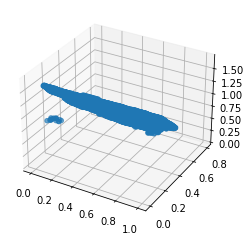

In [4]:
ax = plt.axes(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
ax.scatter(xyz[0,0], xyz[0,1], xyz[0,2], color='red')

In [14]:
plane = pyransac3d.Plane()
best_eq, best_inliers = plane.fit(xyz, 0.01)
a,b,c,d = best_eq
print(f'Equation of plane: {a} x + {b} y + {c} z + {d} = 0')

Equation of plane: -0.021842352752922525 x + 0.9122101112147987 y + 0.40914010390537575 z + -0.7072420983729157 = 0


In [15]:
def get_rotation_mat(M):
    # https://stackoverflow.com/questions/9423621/3d-rotations-of-a-plane
    N = (0,0,1)
    c = np.dot(M,N) 
    x,y,z = np.cross(M,N) / np.linalg.norm(np.cross(M,N))
    s = np.sqrt(1 - c*c)
    C = 1 - c
    rmat = np.array([[ x*x*C+c,    x*y*C-z*s,  x*z*C+y*s ],
                    [ y*x*C+z*s,  y*y*C+c,    y*z*C-x*s ],
                    [ z*x*C-y*s,  z*y*C+x*s,  z*z*C+c   ]])
    return rmat


In [17]:
def get_quaternions(rmat):
     
    r = R.from_matrix(rmat)
    q = r.as_quat()
    return q

rmat = get_rotation_mat([a,b,c])
get_quaternions(rmat)


array([0., 0., 0.])

Equation of plane: 0.004824921971357662 x + -0.0014712649655415648 y + -0.9999872776727569 z + 0.6992890161727533 = 0


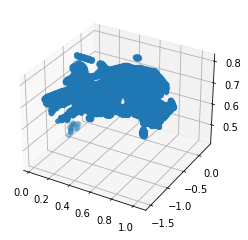

In [8]:
rmat = get_rotation_mat([a,b,c])
xyz_rotated = np.dot(xyz, rmat.T)
assert(xyz.shape==xyz_rotated.shape)
ax = plt.axes(projection='3d')
ax.scatter(xyz_rotated[:,0], xyz_rotated[:,1], xyz_rotated[:,2])
[a,b,c,d], best_inliers = plane.fit(xyz_rotated, 0.01)
print(f'Equation of plane: {a} x + {b} y + {c} z + {d} = 0')

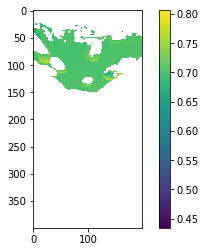

In [10]:
height_map_rotated = xyz_rotated[:,2].reshape((height_map.shape))
plt.imshow(height_map_rotated)
plt.colorbar()
plt.show()

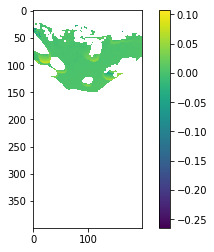

In [13]:
plt.imshow(height_map_rotated - d)
plt.colorbar()
plt.show()

In [47]:

#get the coordinates in the new plane
pos = np.array([0,0,0])
pos_rot = np.dot(rmat, pos) + np.array([0,0, -d])
pos_rot

#get the orientation in the new plane
orientation = np.array([0,0,0,1])
orientation = R.from_quat(orientation)

# orientation = R.from_euler('xyz', [10,0,0], True)
orientation_mat = orientation.as_matrix()
res = np.dot(rmat, orientation_mat)
R.from_matrix(res).as_euler('xyz', True)
R.from_matrix(res).as_quat()




array([0.54337893, 0.0130109 , 0.        , 0.83938671])

In [46]:
R.from_euler('xyz', [10,0,0], True).as_quat()

array([0.08715574, 0.        , 0.        , 0.9961947 ])